In [243]:
import numpy as np
import cv2
from imutils.object_detection import non_max_suppression
from matplotlib import pyplot as plt
from PIL import Image
args = {"image":"../input", "east":"frozen_east_text_detection.pb", "min_confidence":0.5, "width":320, "height":320}

In [244]:
args['image']="images.jpeg"
image = cv2.imread(args['image'])
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
orig = image.copy()
(origH, origW) = image.shape[:2]

In [245]:
newW=320
newH=320
rW = origW / float(newW)
rH = origH / float(newH)

image = cv2.resize(image, (320, 320))
(H, W) = image.shape[:2]
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),(123.68, 116.78, 103.94), swapRB=True, crop=False)

In [246]:
net = cv2.dnn.readNet(args["east"])
layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

In [247]:
import math
def decode(scores, geometry, scoreThresh):
    detections = []
    confidences = []

    assert len(scores.shape) == 4, "Incorrect dimensions of scores"
    assert len(geometry.shape) == 4, "Incorrect dimensions of geometry"
    assert scores.shape[0] == 1, "Invalid dimensions of scores"
    assert geometry.shape[0] == 1, "Invalid dimensions of geometry"
    assert scores.shape[1] == 1, "Invalid dimensions of scores"
    assert geometry.shape[1] == 5, "Invalid dimensions of geometry"
    assert scores.shape[2] == geometry.shape[2], "Invalid dimensions of scores and geometry"
    assert scores.shape[3] == geometry.shape[3], "Invalid dimensions of scores and geometry"
    height = scores.shape[2]
    width = scores.shape[3]
    for y in range(0, height):

        scoresData = scores[0][0][y]
        x0_data = geometry[0][0][y]
        x1_data = geometry[0][1][y]
        x2_data = geometry[0][2][y]
        x3_data = geometry[0][3][y]
        anglesData = geometry[0][4][y]
        for x in range(0, width):
            score = scoresData[x]
            if(score < scoreThresh):
                continue
            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]
            cosA = math.cos(angle)
            sinA = math.sin(angle)
            h = x0_data[x] + x2_data[x]
            w = x1_data[x] + x3_data[x]
            offset = ([offsetX + cosA * x1_data[x] + sinA * x2_data[x], offsetY - sinA * x1_data[x] + cosA * x2_data[x]])
            p1 = (-sinA * h + offset[0], -cosA * h + offset[1])
            p3 = (-cosA * w + offset[0],  sinA * w + offset[1])
            center = (0.5*(p1[0]+p3[0]), 0.5*(p1[1]+p3[1]))
            detections.append((center, (w,h), -1*angle * 180.0 / math.pi))
            confidences.append(float(score))
    return [detections, confidences]

In [248]:
(boxes, confidence_val) = decode(scores, geometry,0.5)

In [249]:
def rot(cnt,img):
    rect = cv2.minAreaRect(cnt)  
    box = cv2.boxPoints(rect) 
    box = np.int0(box)

    W = rect[1][0]
    H = rect[1][1]

    Xs = [i[0] for i in box]
    Ys = [i[1] for i in box]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)

    angle = rect[2]
    if angle < -45:
        angle += 90
    center = ((x1+x2)/2,(y1+y2)/2)
    size = (x2-x1, y2-y1)
    M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)
    cropped = cv2.getRectSubPix(img, size, center)
    cropped = cv2.warpAffine(cropped, M, size)
    croppedW = H if H > W else W
    croppedH = H if H < W else W
    croppedRotated = cv2.getRectSubPix(cropped, (int(croppedW),int(croppedH)), (size[0]/2, size[1]/2))
    return croppedRotated

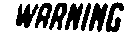

WARNING

चेतावनी




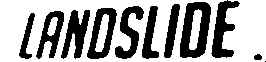

LANDSLIDE .

भूस्खलन ।




In [258]:
import pytesseract
from englisttohindi.englisttohindi import EngtoHindi 
custom_config = r'-l eng --psm 8'
indices = cv2.dnn.NMSBoxesRotated(boxes, confidence_val, 0.5,0.5)
for i in indices:
    vertices = cv2.boxPoints(boxes[i[0]])
    for j in range(4):
        vertices[j][0] *= rW
        vertices[j][1] *= rH
    box = np.int0(vertices)
    cropped=rot(box,orig)
    img = Image.fromarray(cropped, 'RGB')
    cv2.drawContours(orig,[box],0,(0,255,0),2)
    display(img)
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    gray = cv2.bilateralFilter(gray,1,75,75)
    display(Image.fromarray(gray))
    text=pytesseract.image_to_string(gray, config=custom_config)
    print(text)
    res = EngtoHindi(text) 
    print(res.convert)
    print("\n")

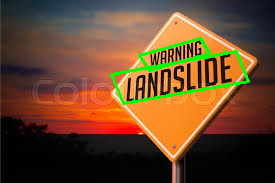

In [251]:
from PIL import Image
img = Image.fromarray(orig, 'RGB')
display(img)